### Song based sentiment analysis using Textblob

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import matutils, models

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

from pprint import pprint

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of n songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,I'm alone because I love you love you with all...
1,Country,Roses I send you roses With all the love their...
2,Country,When The Bees Are In The Hive - Bill Monroe (B...
3,Country,If I can stay away long enough maybe I'll forg...
4,Country,"Familiar, this sounds so familiar You tell me ..."
5,Country,Speed River at my feet running low and flat I'...
6,Country,Beat the drum slowly and play the fife lowly F...
7,Country,"[Verse] I gave you all the love I got, Gave yo..."
8,Country,A well I'll give you love That's above and bey...
9,Country,Once my heart was heavy I was living in sin bu...


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Sentiment Analysis

In [6]:
song_data_processed['Sentiment'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
song_data_processed['Subjectivity'] = song_data_processed['Lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [7]:
song_data_processed

,Genre,Lyrics,Sentiment,Subjectivity
0,Country,i'm alone because i love you love you with all...,0.264286,0.596429
1,Country,roses i send you roses with all the love their...,0.121429,0.357143
2,Country,when the bees are in the hive - bill monroe (b...,0.143778,0.482889
3,Country,if i can stay away long enough maybe i'll forg...,0.149148,0.438542
4,Country,familiar this sounds so familiar you tell me i...,0.173810,0.398810
...,...,...,...,...
9995,Rock,we've sure had the snow for december\njust one...,-0.089379,0.392647
9996,Rock,it's dripping from the ceiling it's everything...,0.225000,0.230000
9997,Rock,we've been a long time comin'\nbut we're here ...,0.064286,0.474542
9998,Rock,tell me what's your drama\nwhat do you want th...,0.195429,0.353429


## LDA

### Remove stopwords and Tokenize

In [8]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [9]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [10]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [11]:
lda.print_topics(num_words=10)

[(0,
  '0.145*"baby" + 0.038*"good" + 0.038*"girl" + 0.023*"boy" + 0.019*"da" + 0.018*"well" + 0.018*"bad" + 0.018*"ah" + 0.016*"need" + 0.016*"crazy"'),
 (1,
  '0.022*"nigga" + 0.020*"shit" + 0.020*"ya" + 0.020*"fuck" + 0.018*"em" + 0.016*"money" + 0.015*"niggas" + 0.015*"bitch" + 0.013*"yo" + 0.012*"man"'),
 (2,
  '0.026*"little" + 0.023*"said" + 0.022*"would" + 0.021*"ever" + 0.015*"man" + 0.013*"yes" + 0.013*"long" + 0.012*"well" + 0.011*"cry" + 0.010*"sweet"'),
 (3,
  '0.035*"around" + 0.032*"keep" + 0.029*"better" + 0.027*"run" + 0.025*"turn" + 0.023*"hold" + 0.019*"head" + 0.019*"people" + 0.019*"play" + 0.016*"hear"'),
 (4,
  '0.028*"us" + 0.028*"la" + 0.027*"world" + 0.014*"fire" + 0.013*"soul" + 0.013*"free" + 0.012*"blood" + 0.011*"heaven" + 0.011*"fight" + 0.010*"die"'),
 (5,
  '0.030*"need" + 0.021*"give" + 0.018*"nothing" + 0.018*"believe" + 0.018*"mind" + 0.017*"think" + 0.015*"much" + 0.015*"find" + 0.013*"try" + 0.013*"always"'),
 (6,
  '0.079*"wanna" + 0.060*"gonna" +

In [12]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,Sentiment,Subjectivity,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,i'm alone because i love you love you with all...,0.264286,0.596429,0.000000,0.000000,0.280880,0.000000,0.000000,0.113195,0.000000,0.161519,0.409102,0.000000,8
1,Country,roses i send you roses with all the love their...,0.121429,0.357143,0.000000,0.000000,0.529905,0.000000,0.161472,0.000000,0.000000,0.267430,0.000000,0.000000,2
2,Country,when the bees are in the hive - bill monroe (b...,0.143778,0.482889,0.000000,0.000000,0.390790,0.000000,0.000000,0.000000,0.000000,0.530877,0.063435,0.000000,7
3,Country,if i can stay away long enough maybe i'll forg...,0.149148,0.438542,0.000000,0.000000,0.000000,0.000000,0.000000,0.642185,0.000000,0.000000,0.329238,0.000000,5
4,Country,familiar this sounds so familiar you tell me i...,0.173810,0.398810,0.045754,0.084609,0.127319,0.000000,0.000000,0.347545,0.257065,0.000000,0.133899,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,we've sure had the snow for december\njust one...,-0.089379,0.392647,0.099989,0.000000,0.063194,0.000000,0.000000,0.247742,0.000000,0.512222,0.000000,0.067235,7
9996,Rock,it's dripping from the ceiling it's everything...,0.225000,0.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.827664,0.000000,0.138994,0.000000,0.000000,5
9997,Rock,we've been a long time comin'\nbut we're here ...,0.064286,0.474542,0.061737,0.000000,0.000000,0.170931,0.000000,0.000000,0.483992,0.216627,0.059247,0.000000,6
9998,Rock,tell me what's your drama\nwhat do you want th...,0.195429,0.353429,0.095227,0.000000,0.000000,0.000000,0.221450,0.331499,0.315024,0.000000,0.000000,0.027537,5


### Explore the results

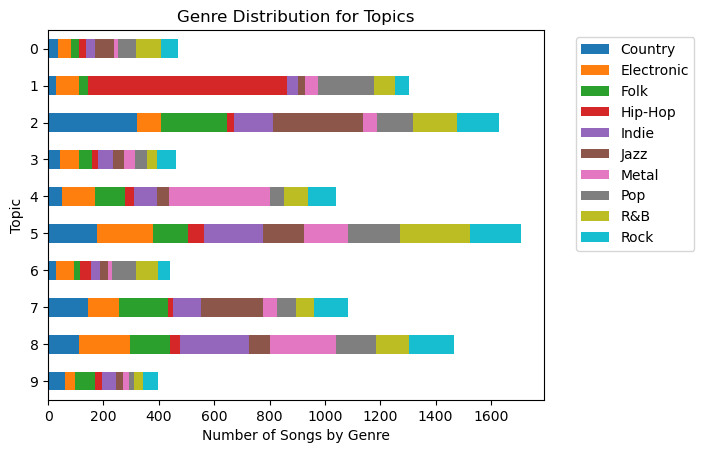

In [13]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

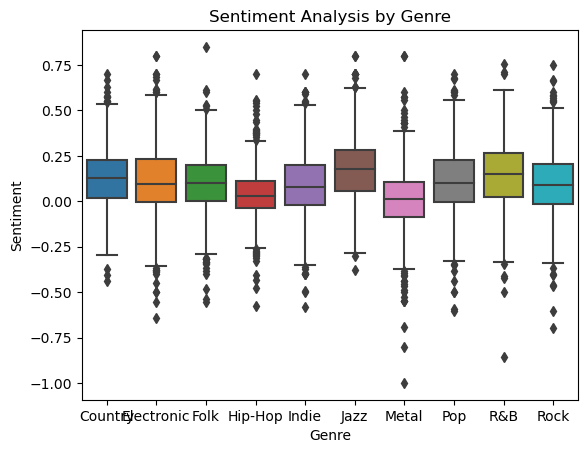

In [14]:
sns.boxplot(x='Genre', y='Sentiment', data=song_data_processed)
plt.title('Sentiment Analysis by Genre')
plt.show()

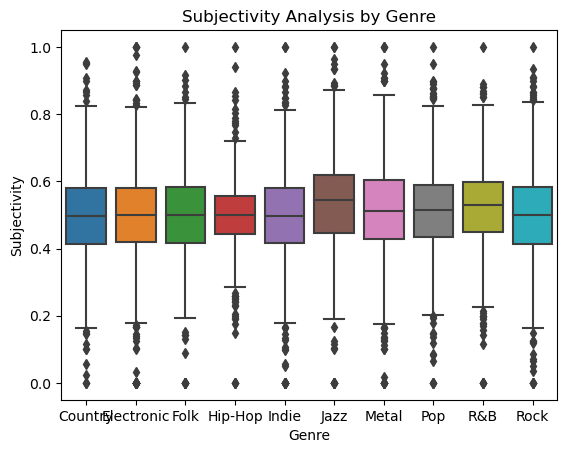

In [15]:
sns.boxplot(x='Genre', y='Subjectivity', data=song_data_processed)
plt.title('Subjectivity Analysis by Genre')
plt.show()

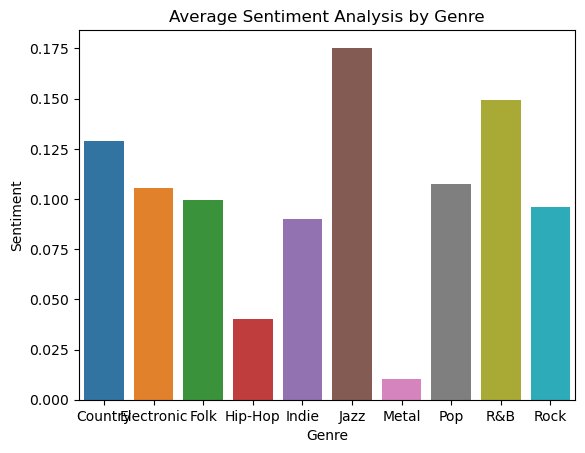

In [16]:
sns.barplot(x='Genre', y='Sentiment', data=song_data_processed, errorbar=None)
plt.title('Average Sentiment Analysis by Genre')
plt.show()

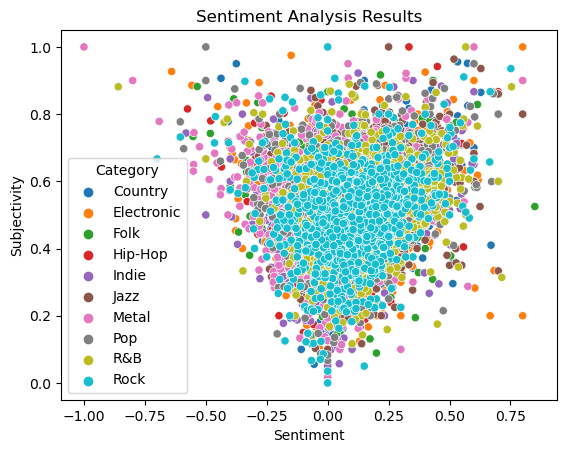

In [17]:
#Scatter Plot
sns.scatterplot(x='Sentiment', y='Subjectivity', hue='Genre', data=song_data_processed)
plt.title('Sentiment Analysis Results')
plt.legend(title='Category')
plt.show()

## Trying classification

In [18]:
results.columns = results.columns.astype(str)
X = results.iloc[:, 2:-1]
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.25366666666666665

In [20]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.2916666666666667

In [21]:
#Random forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.27466666666666667

### Get Classification Matrix (of random forest)

In [22]:
y_pred = rf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.21      0.19      0.20       318
           1       0.19      0.15      0.17       308
           2       0.17      0.18      0.18       288
           3       0.55      0.68      0.61       303
           4       0.17      0.13      0.15       320
           5       0.34      0.41      0.37       290
           6       0.38      0.53      0.44       292
           7       0.18      0.14      0.16       292
           8       0.26      0.26      0.26       324
           9       0.09      0.07      0.08       265

    accuracy                           0.27      3000
   macro avg       0.25      0.27      0.26      3000
weighted avg       0.25      0.27      0.26      3000



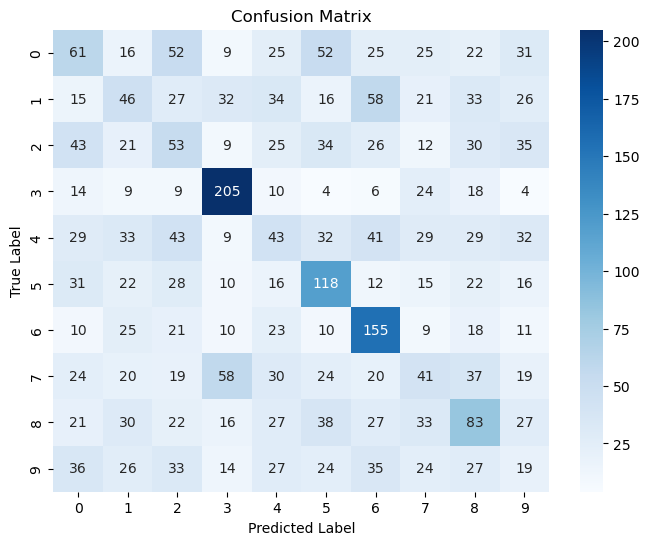

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = rf.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
song_data_processed[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Anwendung der sentiment analyse mithilfe der python textblob bibliothekt (Ergebnis in form von polarity & subjectivity)
- Anwendung von LDA auf die SongLyrics
- Investigating whether the combination of sentiment analysis and LDA can be better to predict a songs genre based on the lyrics than each method on its own

### Ergebnis
- Die Einzelergebnisse von sentiment analyse und LDA sind so wie in den anderen beiden Dokumenten
- Selbst bei der Kombination von sentiment analyse und LDA können die ML-Modelle das Genre eines Liedes nicht besser predicten. 
- Auch hier ist deutlich, dass HipHop songs die einzigen lieder sind, die relativ zuverlässig erkannt werden können
- Dabei weichen allerdings weder f1-score noch accuracy wesentlich ab von den einzelergebnissen der LDA
- Auch Metal songs können allerdings dabei etwas besser erkannt werden, was vermutlich durch die sentiment analyse verstärkt wird, da dieses Genre tendenziell negativer ist
- R&B hat auch leicht erhöhte werte, was daran liegen könnte, dass es bei der Topic Analyse / LDA in nur wenigen Topics vermehrt vorkommt
- Alles in allem ist die performance auf jeden Fall besser als bei der reinen Sentiment analyse
- Verglichen zur LDA ist die accuracy leicht niedriger, dafür gibt es einen besseren overall f1-score. Es gibt außerdem keine Genres mehr mit einem extrem niedrigen f1-score, so wie es bei der LDA mit Pop der Fall war. 
- insgesamt liegen die f1-scores der verschiedenen genres weniger weit auseinander
- der f1-score von HipHop ist noch höher als bei reiner LDA

### Interpretation
- All dies lässt die interpretation zu, dass man durch Kombination beider Ansätze (LDA und sentiment Analyse) tatsächlich eine leichte Verbesserung des Modells erreichen kann
